# TP assemblage de novo avec un dictionnaire Python 

> JC2BIMMM juin 2024 --
> Claire Lemaitre

Quelques manipulations de chaines de caractères en Python

In [81]:
seq = "ATTTCG"
print(seq[:2])
print(seq[4:])
print(seq[0:3])
k=3
for i in range(len(seq)-k+1):
    print(seq[i:i+k])

AT
CG
ATT
ATT
TTT
TTC
TCG


### Dictionnaire pour stocker le graphe de De Bruijn (= les kmers)
**Q1.** Ecrire une fonction `fill_dbg(fasta_file, k)` qui remplit un dictionnaire avec les kmers des séquences présentes dans un fichier fasta donné en entrée. Les clés du dictionnaire sont les kmers distincts et la valeur associée à chaque kmer est son nombre d'occurrences dans les lectures du fichier.

In [82]:
def fill_dbg(fasta_file, k):
    dbg = {}
    with open(fasta_file,"r") as f:
        for line in f:
            line = line.strip()
            if not line.startswith('>'):
                for i in range(len(line)-k+1):
                    kmer = line[i:i+k]
                    if kmer in dbg:
                        dbg[kmer] += 1
                    else:
                        dbg[kmer] = 1
    return dbg

Rq : cette fonction ne marchera pas si la séquence est écrite sur plusieurs lignes (typiquement pour le fichier `ecoli_ref_genome.fasta`). Elle est adaptée pour des fichiers de séquençage.

**Q2.** Appliquer cette fonction sur le fichier contenant le génome de référence du virus sars-cov-2 (fichier `covid_ref_genome.fa`). Indiquer le nombre de kmers totaux et le nombre de kmers distincts.

In [83]:
d31 = fill_dbg("covid_ref_genome.fasta", 31)

In [84]:
def stats_dbg(dbg):
    print(f"{len(dbg.keys())} distinct kmers")
    print(f"{sum(dbg.values())} total kmers")

In [85]:
stats_dbg(d31)

29871 distinct kmers
29873 total kmers


### Histogramme des kmers (ou profil d'abondance des kmers)
**Q3.** Calculer l'histogramme des kmers : écrire une fonction `kmer_histo(dbg, ab_max)` qui renvoie une liste `histo` de taille `ab_max` telle que le `histo[i]` est le nombre de kmers distincts ayant l'abondance `i`.

In [86]:
def kmer_histo(dbg, ab_max = 100):
    histo = [0 for i in range(ab_max)]
    for kmer in dbg:
        abundance = dbg[kmer]
        if abundance < ab_max:
            histo[abundance] += 1
    return histo

**Q4.** Appliquer cette fonction à plusieurs ensembles de kmers calculés sur le génome de référence du sars-cov-2 avec différentes valeurs de $k$ (utiliser `ab_max = 20`). A partir de quelle valeur de $k$, les kmers sont-ils tous (ou presque tous) uniques dans le génome ?

In [87]:
kmer_histo(d31,20)

[0, 29870, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [88]:
d15 = fill_dbg("covid_ref_genome.fasta", 15)
kmer_histo(d15,20)

[0, 29850, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [89]:
d51 = fill_dbg("covid_ref_genome.fasta", 51)
kmer_histo(d51,20) 

[0, 29853, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [90]:
d34 = fill_dbg("covid_ref_genome.fasta", 34)
kmer_histo(d34,20) 

[0, 29870, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**Réponse :** très vite avec k proche de 20, presque tous les kmers n'apparaissent qu'une seule fois dans le génome. A partir de k=34, ils sont tous uniques. C'est parce qu'il s'agit d'un petit génome, de virus, avec aucune répétition de taille $>32$.

### Assemblage : construction d'unitigs
**Q5.** On construira un unitig à partir d'un kmer arbitraire du graphe, qu'on va étendre vers la droite. Récupérer un kmer arbitraire du graphe à l'aide de la fonction `keys()`.

In [91]:
import random
print(list(d34.keys())[0])
print(list(d34.keys())[0])
print(next(iter(d34)))
print(next(iter(d34)))
print(random.choice(list(d34.keys())))
print(random.choice(list(d34.keys())))
starter = list(d34.keys())[0]

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCA
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCA
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCA
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCA
TATGGTGCTAGATTTTACTTTTACACCAGTAAAA
GCCACCTTTGCTCACAGATGAAATGATTGCTCAA


**Q6.** Implémenter les fonctions `left_neighbors(kmer, dbg)` et `right_neighbors(kmer, dbg)` qui renvoient une liste des kmers voisins à gauche et à droite respectivement d'un kmer donné du graphe de De Bruin.

*Astuce : il faudra d'abord identifier quels sont les kmers voisins possibles, puis interroger leur existence dans le dictionnaire.*

In [92]:
seq = 'ATTTCG'
seq[:-1]

'ATTTC'

In [93]:
def right_neighbors(kmer, dbg):
    res = []
    for letter in ["A","C","G","T"]:
        voisin = kmer[1:] + letter
        if voisin in dbg:
            res.append(voisin)
    return res

In [94]:
def left_neighbors(kmer, dbg):
    res = []
    for letter in ["A","C","G","T"]:
        voisin = letter + kmer[:-1]
        if voisin in dbg:
            res.append(voisin)
    return res

**Q7.** Ecrire la fonction `right_unitig(kmer, dbg)` qui renvoie la séquence de l’extension à droite sans branchement (unitig) d’un k-mer donné (incluant le k-mer).

In [95]:
def right_unitig(kmer,dbg):
    unitig = kmer
    current_kmer = kmer
    while True:
        voisins = right_neighbors(current_kmer, dbg)
        if len(voisins) == 1:
            if voisins[0] == kmer:
                print("stop because loop")
                break
            if len(left_neighbors(voisins[0], dbg))==1:  
                unitig += voisins[0][-1]
                current_kmer = voisins[0]
            else:  # le voisin à droite est branchant à gauche
                print("stop because multiple incoming edges")
                break
        elif len(voisins) == 0:
            print("stop because no right neighbors")
            break
        elif len(voisins) >1:
            print("stop because more than one right neighbors")
            break
            
    return unitig

**Q8.** Appliquer cette fonction à un kmer arbitraire du graphe. Quelle taille d'unitig arrive-t-on à reconstruire avec les kmers du génome de référence ?

In [96]:
unitig = right_unitig(starter,d34)

stop because no right neighbors


In [97]:
len(unitig)

29903

In [98]:
len(right_unitig(random.choice(list(d34.keys())),d34))

stop because no right neighbors


26054

**Réponse :** on reconstruit le génome en entier car il n'y a pas de kmer répété. Mais c'est parce qu'on est parti du premier kmer du génome linéaire (Python a organisé les clés du dictionnaire dans l'ordre où il les a vu). Comme le génome n'est pas circulaire, on ne peut pas retrouver tout le génome en allant que vers la droite à partir d'un kmer arbitraire. On peut le faire si on fait 2 extensions, une vers la droite et une vers la gauche.

### Tests sur un vrai jeu de données de séquençage du Sars-Cov-2
Le fichier fasta `SRX9435498_subset10000.fasta` contient un sous-ensemble de 10000 lectures du jeu de données [SRX9435498](https://www.ncbi.nlm.nih.gov/sra/?term=SRX9435498) disponible dans SRA. Il s'agit d'un séquençage Illumina par capture amplicon du sars-cov-2 depuis un prélèvement chez un patient américain (nouveau mexique) lors de la pandémie en 2020.

**Q9.** Créer le graphe de De Bruijn pour ce fichier avec `k=31`, et indiquer le nombre de kmers totaux et distincts. Comparer le nombre de kmers distincts avec celui du génome de référence et expliquer cette différence. Calculer l'histogramme des kmers. Que remarque-t-on par rapport à l'histogramme calculé sur le génome de référence ?

In [99]:
real31 = fill_dbg("SRX9435498_subset10000.fasta", 31)
stats_dbg(real31)

97000 distinct kmers
1091629 total kmers


In [100]:
h = kmer_histo(real31,100)
h

[0,
 38255,
 1195,
 1194,
 1457,
 1537,
 1715,
 2172,
 1994,
 2196,
 2122,
 2079,
 2288,
 2050,
 2299,
 2427,
 2613,
 2176,
 2337,
 2309,
 2117,
 1932,
 1815,
 1937,
 1606,
 1488,
 1478,
 1297,
 1229,
 1080,
 945,
 907,
 653,
 574,
 614,
 447,
 362,
 289,
 294,
 234,
 234,
 190,
 186,
 91,
 88,
 112,
 109,
 70,
 77,
 38,
 20,
 14,
 15,
 5,
 11,
 2,
 0,
 3,
 2,
 2,
 5,
 9,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

**Réponse :** beaucoup de kmers d'abondance 1 -> des kmers contenant une erreur de séquençage.

**Q10.** Représenter graphiquement cet histogramme, par exemple la fonction `pyplot` du package `matplotlib`, ou alors en utilisant R.

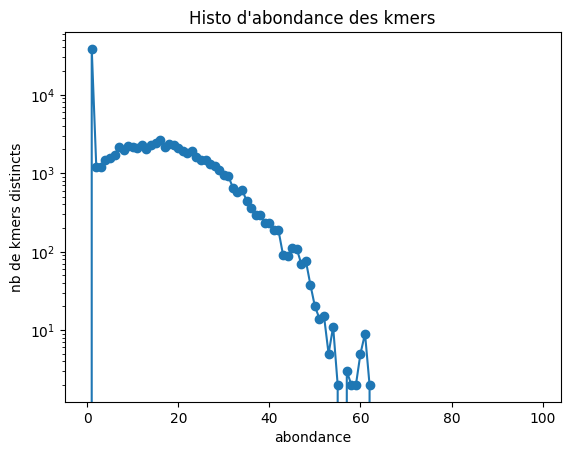

In [101]:
import matplotlib.pyplot as plt
def plot_histogram(dbg, ab_max = 100):

    h = kmer_histo(dbg, ab_max)
    plt.figure()

    # Tracé des données
    plt.plot(range(ab_max), h, marker='o', linestyle='-')
    plt.yscale('log')
    # Ajout des titres et des étiquettes
    plt.title("Histo d'abondance des kmers")
    plt.xlabel('abondance')
    plt.ylabel('nb de kmers distincts')

    # Affichage de la figure
    plt.show()
plot_histogram(real31,100)

**Q11.** Nous allons tenter de construire un unitig à partir d'un kmer de départ. Proposer une fonction qui permet de choisir un kmer plus judicieux que le premier de la liste.

*Astuce : utiliser l'information d'abondance...*

In [102]:
import random

def pick_starter(dbg, abundance):
    # starter = le premier kmer d'abondance X 
    starter = ""
    for kmer in dbg:
        if dbg[kmer] == abundance:
            starter = kmer
            break
    return starter
def random_starter(dbg, abundance):
    # starter = un kmer random parmi tous ceux d'abondance X 
    liste = [k for k, v in dbg.items() if v == abundance]
    return random.choice(liste)

In [103]:
starter = pick_starter(real31, 20)
starter

'ATTATTGGGTAAACCTTGGGGCCGACGTTGT'

**Q12.** Calculer l'extension en unitig vers la droite pour ce kmer. Quelle taille d'unitig obtient-on ?

In [104]:
len(right_unitig(starter,real31))

stop because multiple incoming edges


34

In [105]:
print(len(right_unitig(random_starter(real31,20),real31)))
print(len(right_unitig(random_starter(real31,20),real31)))
print(len(right_unitig(random_starter(real31,20),real31)))
print(len(right_unitig(random_starter(real31,20),real31)))

stop because multiple incoming edges
42
stop because more than one right neighbors
201
stop because multiple incoming edges
115
stop because more than one right neighbors
120


**Réponse :** unitigs tout petits. Du aux erreurs de séquençage qui créent pleins de kmers branchants.

## Nettoyer le graphe des kmers erronés
**Q13.** Ecrire une fonction `remove_low_abundance(dbg, min_ab)` qui élimine du dictionnaire les kmers dont l'abondance est inférieure au seuil `min_ab`.

In [106]:
# 2 versions 
def remove_low_abundance_1(dbg, min_ab):
    for kmer in list(dbg.keys()):
        if dbg[kmer]<min_ab:
            del dbg[kmer]
    return dbg
def remove_low_abundance(dbg, min_ab):
    new_dico = {k: v for k, v in dbg.items() if v >= min_ab}
    return new_dico

**Q14.** Appliquer la fonction avec le seuil = 2 et recalculer les statistiques de nombre de kmers totaux et distincts. Est-ce que le nombre de kmers distincts vous parait cohérent avec la taille du génome du sars-cov-2 ?

In [107]:
real31_clean = remove_low_abundance(real31, 2)
stats_dbg(real31_clean)

58745 distinct kmers
1053374 total kmers


**Réponse :** On observe 2x plus de kmers que la taille du génome. Car on a les deux versions de chaque kmer du génome de ref : le fwd + revcomp.

**Q15.** Re-calculer l'extension en unitig du kmer `starter` précédent avec ce nouveau graphe filtré. A-t-on augmenté la taille de l'extension ? 

In [108]:
print(len(right_unitig(starter,real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))

stop because no right neighbors
609
stop because more than one right neighbors
1322
stop because no right neighbors
4155
stop because no right neighbors
524
stop because more than one right neighbors
84


**Réponse :** Les unitigs sont encore assez petits. D'après les causes d'arrêt, plusieurs pistes d'explication :
* probablement pas assez de couverture (on voyait sur l'histiogramme que la distribution était tronquée). On peut essayer avec une plus petite valeur de k, ou avec un jeu de données avec plus de lectures.
* encore des erreurs de séquençage non filtrés par l'abondance.

**Q16.** Ré-essayer avec un autre kmer starter, ou avec une plus petite valeur de $k$.  

In [109]:
def pipeline(fasta_file, k=31, min_ab=2):
    dbg = fill_dbg(fasta_file, k)
    dbg_clean = remove_low_abundance(dbg, min_ab)
    stats_dbg(dbg_clean)
    return dbg_clean

In [110]:
real25_clean = pipeline("SRX9435498_subset10000.fasta", 25, 2)
print(len(right_unitig(random_starter(real25_clean,20),real25_clean)))
print(len(right_unitig(random_starter(real25_clean,20),real25_clean)))
print(len(right_unitig(random_starter(real25_clean,20),real25_clean)))
print(len(right_unitig(random_starter(real25_clean,20),real25_clean)))

58901 distinct kmers
1117252 total kmers
stop because more than one right neighbors
3192
stop because no right neighbors
655
stop because more than one right neighbors
249
stop because no right neighbors
199


**Q17.** Tester avec un jeu contenant 3x plus de lectures, `SRX9435498_subset30000.fasta`.

In [111]:
real30K_31 = pipeline("SRX9435498_subset30000.fasta", 31, 2)
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))
print(len(right_unitig(random_starter(real31_clean,20),real31_clean)))

62923 distinct kmers
3166256 total kmers
stop because more than one right neighbors
1783
stop because more than one right neighbors
1909
stop because more than one right neighbors
1364
stop because more than one right neighbors
1955


## Nettoyer encore plus le graphe : enlever les tips et les bulles
On commence par enlever les tips : unitigs de taille $<k$ (en nombre de noeuds) qui n'ont pas de successeur. On enlèvera après les bulles de taille exactement $k$ (en nombre de noeuds).

**Q18.** Ecrire une fonction `remove_tips(dbg)` qui renvoie un nouveau dbg dans lequel les noeuds des tips ont été enlevés. Pour cela, on parcourt tous les noeuds du graphe ayant exactement 2 successeurs. Pour ces noeuds, la fonction calcule les deux extensions possibles vers la droite, et si l'une est de taille $<k$ (en nombre de noeuds), alors la fonction élimine du graphe tous les noeuds qui composent cette extension. 

In [112]:
# re-write the right-unitig function in order to get the info why the unitig stopped
def right_unitig2(kmer,dbg):
    unitig = kmer
    current_kmer = kmer
    while True:
        voisins = right_neighbors(current_kmer, dbg)
        if len(voisins) == 1:
            if voisins[0] == kmer:
                return "loop", unitig
            if len(left_neighbors(voisins[0], dbg))==1: 
                unitig += voisins[0][-1]
                current_kmer = voisins[0]
            else: # le voisin à droite est branchant à gauche
                return "left", unitig
        elif len(voisins) == 0:
            return "end", unitig
        elif len(voisins) >1:
            return "right", unitig

In [113]:
def remove_tips(dbg):
    k = len(list(dbg.keys())[0])
    list_to_remove = []
    for kmer in dbg.keys():
        neighbors = right_neighbors(kmer, dbg)
        if len(neighbors)==2:
            stop1, unitig1 = right_unitig2(neighbors[0],dbg)
            stop2, unitig2 = right_unitig2(neighbors[1],dbg)
            if stop1 == "end" and len(unitig1)<2*k-1:
                for i in range(len(unitig1) - k + 1):
                    list_to_remove.append(unitig1[i:i+k])
            if stop2 == "end" and len(unitig2)<2*k-1:
                for i in range(len(unitig2) - k + 1):
                    list_to_remove.append(unitig2[i:i+k])
    print(f"{len(list_to_remove)} kmers in tips to remove")
    # removing these kmers
    new_dico = {k: v for k, v in dbg.items() if k not in list_to_remove}
    return new_dico

In [114]:
dbg2 = remove_tips(real30K_31)

922 kmers in tips to remove


**Réponse :** quelques tips, on peut comparer avec le graphe sans filtre d'abondance.

In [115]:
test = remove_tips(real31)

3395 kmers in tips to remove


**Q19.** Ecrire une fonction `reduce_bubbles(dbg)` qui renvoie un nouveau dbg dans lequel les noeuds d'un des deux chemins de chaque bulle de taille $k$ ont été enlevés. Pour cela, on parcourt tous les noeuds du graphe ayant exactement 2 successeurs. Pour ces noeuds, la fonction calcule les deux extensions possibles vers la droite, et si les deux sont de taille $k$, alors la fonction élimine du graphe tous les noeuds qui composent l'une des deux extensions. 

In [116]:
def reduce_bubbles(dbg):
    k = len(list(dbg.keys())[0])
    list_to_remove = []
    for kmer in dbg.keys():
        neighbors = right_neighbors(kmer, dbg)
        if len(neighbors)==2:
            stop1, unitig1 = right_unitig2(neighbors[0],dbg)
            stop2, unitig2 = right_unitig2(neighbors[1],dbg)
            if stop1 == "left" and len(unitig1)== 2*k-1 and stop2 == "left" and len(unitig2)==2*k-1:
                # arbitrary choice to remove the first path
                for i in range(len(unitig1) - k + 1):
                    list_to_remove.append(unitig1[i:i+k])
    print(f"{len(list_to_remove)} kmers in bubbles to remove")
    # removing these kmers
    new_dico = {k: v for k, v in dbg.items() if k not in list_to_remove}
    return new_dico

In [117]:
dbg2 = reduce_bubbles(real30K_31)

651 kmers in bubbles to remove


In [118]:
dbg2 = reduce_bubbles(real31)

4371 kmers in bubbles to remove


**Q20.** Appliquer ces focntions sur les jeux de données réelles et observer si cela améliore la taille des unitigs qu'on peut construire.

In [119]:
dbg_final = reduce_bubbles(remove_tips(real30K_31))

922 kmers in tips to remove
744 kmers in bubbles to remove


On note qu'il vaut mieux d'abord enlever les tips, puis les bubbles. Après avoir enlevé les tips, on trouve plus de bubbles.

## Prendre en compte le reverse-complément
Pour une lecture donnée, on va considérer qu'on la "voit" à la fois en forward et en reverse-complément et un noeud du graphe représente les deux versions du kmer vu dans la lecture. On utilise sa représentation "canonique" : le plus petit mot au sens lexicographique entre le kmer et son reverse complement.

**Q21.** Implémenter la fonction `rev_comp(sequence)` qui renvoie le reverse-complément d'une séquence d'ADN, ainsi que la fonction `canonical(sequence)`  qui renvoie la version canonique d'une séquence d'ADN.

In [120]:
baseComplement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
def rev_comp(sequence):
    S=''.join([baseComplement[base] for base in reversed(list(sequence))])
    return S
def canonical(sequence):
    return min(sequence,rev_comp(sequence))

In [121]:
canonical("ATTCGT")

'ACGAAT'

**Q22.** Ré-implémenter les fonctions qui construisent le graphe et calculent les voisins pour prendre en compte les kmers canoniques. Et appliquer sur les jeux de données pour observer si cela améliore la taille des unitigs.

In [122]:
def fill_dbg_canonical(fasta_file, k):
    dbg = {}
    with open(fasta_file,"r") as f:
        for line in f:
            line = line.strip()
            if not line.startswith('>'):
                for i in range(len(line)-k+1):
                    kmer = canonical(line[i:i+k])
                    if kmer in dbg:
                        dbg[kmer] += 1
                    else:
                        dbg[kmer] = 1
    return dbg

#On ne renomme pas les fonctions, comme cela pas besoin de modifier le code des fonctions d'unitig.
def right_neighbors(kmer, dbg):
    res = []
    for letter in ["A","C","G","T"]:
        voisin = kmer[1:] + letter
        if canonical(voisin) in dbg:
            res.append(voisin)
    return res

def left_neighbors(kmer, dbg):
    res = []
    for letter in ["A","C","G","T"]:
        voisin = letter + kmer[:-1]
        if canonical(voisin) in dbg:
            res.append(voisin)
    return res

In [123]:
def pipeline_canonical(fasta_file, k=31, min_ab=2):
    dbg = fill_dbg_canonical(fasta_file, k)
    dbg_clean = remove_low_abundance(dbg, min_ab)
    dbg_final = reduce_bubbles(remove_tips(dbg_clean))  
    stats_dbg(dbg_final)
    return dbg_final

In [124]:
final = pipeline_canonical("SRX9435498_subset30000.fasta", 31, 3)

281 kmers in tips to remove
186 kmers in bubbles to remove
30662 distinct kmers
3158037 total kmers


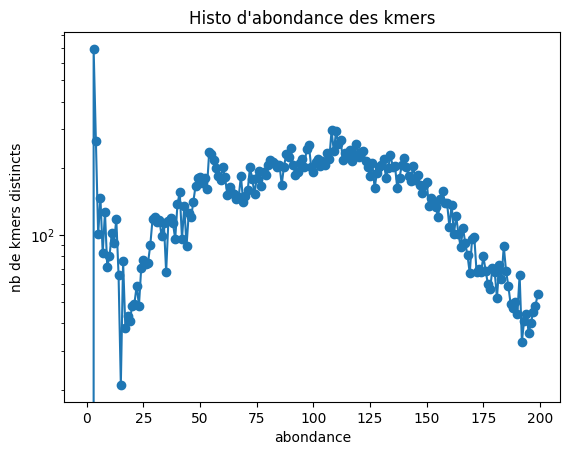

In [125]:
plot_histogram(final,200)

On pourrait mieux choisir notre seuil d'abondance...

In [126]:
final = pipeline_canonical("SRX9435498_subset30000.fasta", 31, 10)

20 kmers in tips to remove
62 kmers in bubbles to remove
29189 distinct kmers
3154076 total kmers


In [127]:
starter = random_starter(final,90)
uright = right_unitig(starter,final)
len(uright)

stop because no right neighbors


1557

Avec cette fonction rev_comp, on peut aussi calculer l'extension vers la gauche sans ré-implémenter la fonction d'unitigage :

In [128]:
uleft = rev_comp(right_unitig(rev_comp(starter),final))
len(uleft)

stop because more than one right neighbors


3414

On obtient un grand unitig (attention à enlever la redondance du kmer starter qui est présent au début de l'unitig à droite et à la fin de l'unitig à gauche) ! Peut-on reconstruire tout le génome ? Et en combien d'unitigs ?

**Q23.** Ecrire une fonction qui calcule tous les unitigs du jeu de données. 

*Astuce : On peut ré-utiliser la fonction qui calcule l'extension en unitig vers la droites, l'appliquer vers la gauche pour avoir un unitig complet. Il faudra parcourir les kmers du graphes pour choisir ses kmers de départ et surtout faire en sorte d'éviter de ré-assembler des kmers déjà assemblés...*